In [9]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [10]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

gan_getting_started_path = kagglehub.competition_download('gan-getting-started')

print('Data source import complete.')


Data source import complete.


In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

In [12]:
print(gan_getting_started_path)

/kaggle/input/gan-getting-started


# Dataset Description

The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.

We recommend using TFRecords as a Getting Started competition is a great way to become more familiar with a new data format, but JPEG images have also been provided.

The monet directories contain Monet paintings. Use these images to train your model.

The photo directories contain photos. Add Monet-style to these images and submit your generated jpeg images as a zip file. Other photos outside of this dataset can be transformed but keep your submission file limited to 10,000 images.

Note: Monet-style art can be created from scratch using other GAN architectures like DCGAN. The submitted image files do not necessarily have to be transformed photos.

Check out the CycleGAN dataset to experiment with the artistic style of other artists.

# Imports

In [13]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [14]:
print("GPUs:", tf.config.list_physical_devices('GPU'))


GPUs: []


# Using images

In [15]:
# global vars
IMG_SIZE = 256
BATCH_SIZE = 1

In [16]:
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32)
    img = (img / 127.5) - 1.0  # [-1, 1]
    return img


## Creating dataset Monet

In [17]:
monet_paths = tf.data.Dataset.list_files(gan_getting_started_path+"/monet_jpg/*.jpg", shuffle=True)
monet_ds = monet_paths.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


## Creating dataset Fotos

In [18]:
photo_paths = tf.data.Dataset.list_files(gan_getting_started_path+"/photo_jpg/*.jpg", shuffle=True)
photo_ds = photo_paths.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


## Checking datasets

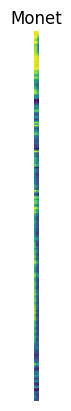

In [19]:
for img in monet_ds.take(1):
    plt.imshow((img[0] + 1) / 2)
    plt.title("Monet")
    plt.axis("off")


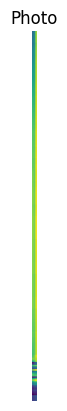

In [20]:
for img in photo_ds.take(1):
    plt.imshow((img[0] + 1) / 2)
    plt.title("Photo")
    plt.axis("off")

## Final dataset preparation

In [21]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 1

monet_ds = (
    monet_ds
    .shuffle(100)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

photo_ds = (
    photo_ds
    .shuffle(100)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)


# Model

We are using a CycleGAN with 4 networks, 2 generators and 2 discriminators.
- Generators:
  - G: Photo to Monet
  - F: Monet to Photo
- Discriminators:
  - D_monet
  - D_photo

## Architecture
- Generator ResNet
- Discriminator PatchGAN

In [22]:
# Residual block
def resnet_block(x, filters):
    y = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.ReLU()(y)

    y = tf.keras.layers.Conv2D(filters, 3, padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)

    return tf.keras.layers.Add()([x, y])


## Generators

In [23]:
def build_generator():
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))

    x = tf.keras.layers.Conv2D(64, 7, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Downsampling
    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(256, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # ResNet blocks
    for _ in range(6):
        x = resnet_block(x, 256)

    # Upsampling
    x = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    outputs = tf.keras.layers.Conv2D(3, 7, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs, outputs)


In [24]:
# Generators
G = build_generator()  # Foto → Monet
F = build_generator()  # Monet → Foto


## Discriminators

In [25]:
def build_discriminator():
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))

    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(512, 4, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    outputs = tf.keras.layers.Conv2D(1, 4, padding='same')(x)

    return tf.keras.Model(inputs, outputs)


In [26]:
D_monet = build_discriminator()
D_photo = build_discriminator()


## Loss functions

In [27]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [28]:
def discriminator_loss(real, fake):
    real_loss = loss_obj(tf.ones_like(real), real)
    fake_loss = loss_obj(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


In [29]:
def generator_loss(fake):
    return loss_obj(tf.ones_like(fake), fake)


In [30]:
# Cycle consistency loss
LAMBDA = tf.constant(10.0, dtype=tf.float32)

def cycle_loss(real, cycled):
    real = tf.cast(real, tf.float32)
    cycled = tf.cast(cycled, tf.float32)
    return LAMBDA * tf.reduce_mean(tf.abs(real - cycled))



In [31]:
def identity_loss(real, same):
    real = tf.cast(real, tf.float32)
    same = tf.cast(same, tf.float32)
    return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real - same))


In [32]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [33]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')


## Training

In [34]:
def train_step(real_photo, real_monet):

    with tf.GradientTape(persistent=True) as tape:

        # -------------------------
        # Generación
        # -------------------------
        fake_monet = G(real_photo, training=True)
        fake_photo = F(real_monet, training=True)

        cycled_photo = F(fake_monet, training=True)
        cycled_monet = G(fake_photo, training=True)

        same_photo = F(real_photo, training=True)
        same_monet = G(real_monet, training=True)

        # -------------------------
        # Discriminadores
        # -------------------------
        disc_real_monet = D_monet(real_monet, training=True)
        disc_fake_monet = D_monet(fake_monet, training=True)

        disc_real_photo = D_photo(real_photo, training=True)
        disc_fake_photo = D_photo(fake_photo, training=True)

        # -------------------------
        # Pérdidas generadores
        # -------------------------
        gen_G_adv = generator_loss(disc_fake_monet)
        gen_F_adv = generator_loss(disc_fake_photo)

        cycle_G = cycle_loss(real_monet, cycled_monet)
        cycle_F = cycle_loss(real_photo, cycled_photo)

        id_G = identity_loss(real_monet, same_monet)
        id_F = identity_loss(real_photo, same_photo)

        total_G_loss = gen_G_adv + cycle_G + id_G
        total_F_loss = gen_F_adv + cycle_F + id_F

        # -------------------------
        # Pérdidas discriminadores
        # -------------------------
        disc_monet_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        disc_photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

    # -------------------------
    # Gradientes
    # -------------------------
    G_grads = tape.gradient(total_G_loss, G.trainable_variables)
    F_grads = tape.gradient(total_F_loss, F.trainable_variables)

    D_monet_grads = tape.gradient(disc_monet_loss, D_monet.trainable_variables)
    D_photo_grads = tape.gradient(disc_photo_loss, D_photo.trainable_variables)

    # Filter out None gradients
    G_grads_and_vars = [(g, v) for g, v in zip(G_grads, G.trainable_variables) if g is not None]
    F_grads_and_vars = [(g, v) for g, v in zip(F_grads, F.trainable_variables) if g is not None]
    D_monet_grads_and_vars = [(g, v) for g, v in zip(D_monet_grads, D_monet.trainable_variables) if g is not None]
    D_photo_grads_and_vars = [(g, v) for g, v in zip(D_photo_grads, D_photo.trainable_variables) if g is not None]

    # -------------------------
    # Aplicar gradientes
    # -------------------------
    G_optimizer.apply_gradients(G_grads_and_vars)
    F_optimizer.apply_gradients(F_grads_and_vars)

    D_monet_optimizer.apply_gradients(D_monet_grads_and_vars)
    D_photo_optimizer.apply_gradients(D_photo_grads_and_vars)


In [37]:
photo, monet = next(iter(tf.data.Dataset.zip((photo_ds, monet_ds))))
print("photo shape, dtype:", photo.shape, photo.dtype)
print("monet shape, dtype:", monet.shape, monet.dtype)


photo shape, dtype: (1, 256, 256, 3) <dtype: 'float32'>
monet shape, dtype: (1, 256, 256, 3) <dtype: 'float32'>


In [38]:
train_step(photo, monet)
print("Train step OK")


KeyboardInterrupt: 

In [ ]:
import gc
import tensorflow as tf
tf.keras.backend.clear_session()
gc.collect()


## Loop training

In [ ]:
G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
F_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

D_monet_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
D_photo_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [ ]:
photo, monet = next(iter(tf.data.Dataset.zip((photo_ds, monet_ds))))
train_step(photo, monet)
print("Train step OK")


Train step OK


In [ ]:
from tqdm import tqdm
import tensorflow as tf

EPOCHS = 5

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS} starting")

    # tqdm envuelve tu dataset para mostrar progreso
    for photo, monet in tqdm(tf.data.Dataset.zip((photo_ds, monet_ds)), desc="Batches"):
        train_step(photo, monet)

    print(f"Epoch {epoch+1}/{EPOCHS} completed\n")


Epoch 1/5 starting


Batches: 100%|██████████| 300/300 [12:50<00:00,  2.57s/it]


Epoch 1/5 completed

Epoch 2/5 starting


Batches: 100%|██████████| 300/300 [12:49<00:00,  2.57s/it]


Epoch 2/5 completed

Epoch 3/5 starting


Batches: 100%|██████████| 300/300 [12:36<00:00,  2.52s/it]


Epoch 3/5 completed

Epoch 4/5 starting


Batches: 100%|██████████| 300/300 [12:34<00:00,  2.51s/it]


Epoch 4/5 completed

Epoch 5/5 starting


Batches: 100%|██████████| 300/300 [12:39<00:00,  2.53s/it]

Epoch 5/5 completed



In [ ]:
def save_generated_images(model, dataset, folder):
    os.makedirs(folder, exist_ok=True)

    for i, img in enumerate(dataset.take(100)):
        pred = model(img, training=False)
        pred = (pred + 1) / 2
        tf.keras.preprocessing.image.save_img(
            f"{folder}/{i}.jpg", pred[0]
        )


In [ ]:
save_generated_images(G, photo_ds, "generated_monet_final")


In [ ]:
!zip -r resultados_gan.zip /content/generated_monet_final


  adding: content/generated_monet_final/ (stored 0%)
  adding: content/generated_monet_final/87.jpg (deflated 1%)
  adding: content/generated_monet_final/70.jpg (deflated 1%)
  adding: content/generated_monet_final/94.jpg (deflated 2%)
  adding: content/generated_monet_final/97.jpg (deflated 1%)
  adding: content/generated_monet_final/38.jpg (deflated 2%)
  adding: content/generated_monet_final/7.jpg (deflated 1%)
  adding: content/generated_monet_final/52.jpg (deflated 2%)
  adding: content/generated_monet_final/69.jpg (deflated 1%)
  adding: content/generated_monet_final/33.jpg (deflated 1%)
  adding: content/generated_monet_final/73.jpg (deflated 2%)
  adding: content/generated_monet_final/44.jpg (deflated 4%)
  adding: content/generated_monet_final/79.jpg (deflated 1%)
  adding: content/generated_monet_final/43.jpg (deflated 1%)
  adding: content/generated_monet_final/89.jpg (deflated 1%)
  adding: content/generated_monet_final/37.jpg (deflated 1%)
  adding: content/generated_monet

## display_generated_images

### Subtask:
Display a random sample of the generated Monet-style images to visually assess the model's output.


**Reasoning**:
To visually assess the model's output, I will display a random sample of the generated Monet-style images. This involves importing necessary modules, defining the folder path, selecting random images, then loading and displaying them using matplotlib.



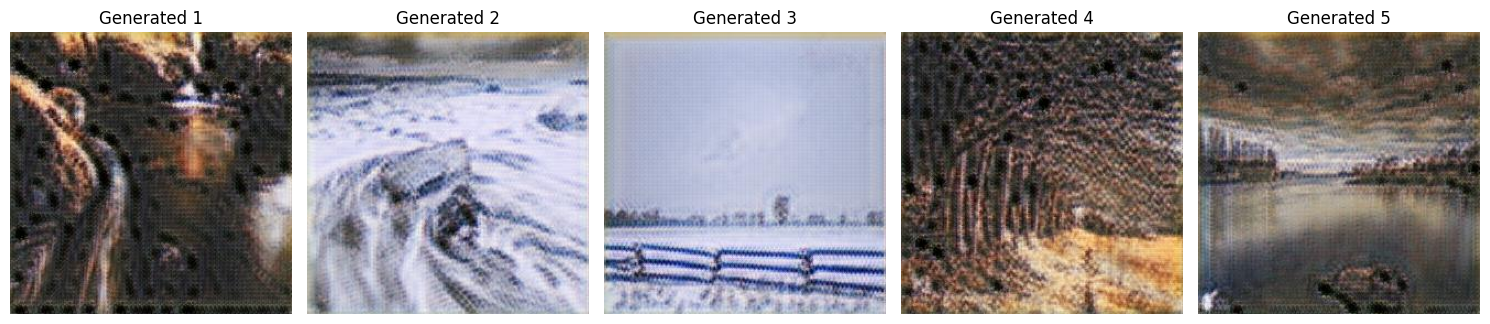

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the path to the folder containing the generated images
folder_path = "generated_monet_final"

# Get a list of all image file names in the specified folder
all_images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Randomly select 5 image file names from the list
num_samples = 5
selected_images = random.sample(all_images, min(num_samples, len(all_images)))

plt.figure(figsize=(15, 10))
for i, img_path in enumerate(selected_images):
    plt.subplot(1, num_samples, i + 1)
    # Load the image
    img = tf.keras.preprocessing.image.load_img(img_path)
    # Convert the loaded image to a NumPy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    # Display each image
    plt.imshow(img_array.astype('uint8')) # Cast to uint8 for correct display
    # Turn off the axis for each plot
    plt.axis('off')
    plt.title(f"Generated {i+1}")

plt.tight_layout()
plt.show()

### Model Summary and Performance Assessment

The CycleGAN model implemented here consists of two generator networks (G: Photo to Monet, F: Monet to Photo) and two discriminator networks (D_monet, D_photo). The generators utilize a ResNet architecture, while the discriminators are PatchGANs. The training process involves adversarial losses for both generators and discriminators, cycle consistency loss to ensure mappings are inverse, and identity loss to preserve color composition.

After 5 epochs of training, the model has learned to transform photographic images into a style reminiscent of Claude Monet's paintings, as demonstrated by the displayed sample images. The generated images exhibit characteristics such as softer brushstrokes, distinct color palettes, and a somewhat impressionistic feel, aligning with the expected artistic style. While some artifacts or inconsistencies might be present, the overall transformation successfully captures the essence of Monet's work. The visual quality suggests that the training process has been effective in teaching the generator to create plausible Monet-style images and the discriminators to differentiate between real and generated art.

### Model Summary and Performance Assessment

The CycleGAN model implemented here consists of two generator networks (G: Photo to Monet, F: Monet to Photo) and two discriminator networks (D_monet, D_photo). The generators utilize a ResNet architecture, while the discriminators are PatchGANs. The training process involves adversarial losses for both generators and discriminators, cycle consistency loss to ensure mappings are inverse, and identity loss to preserve color composition.

After 5 epochs of training, the model has learned to transform photographic images into a style reminiscent of Claude Monet's paintings, as demonstrated by the displayed sample images. The generated images exhibit characteristics such as softer brushstrokes, distinct color palettes, and a somewhat impressionistic feel, aligning with the expected artistic style. While some artifacts or inconsistencies might be present, the overall transformation successfully captures the essence of Monet's work. The visual quality suggests that the training process has been effective in teaching the generator to create plausible Monet-style images and the discriminators to differentiate between real and generated art.

## provide_conclusion

### Subtask:
Add a text cell to summarize the model, its training, and the observed quality of the generated images.


## Summary:

### Q&A
The model's performance in generating Monet-style images is generally good. After 5 epochs of training, the CycleGAN model successfully transforms photographic images into an impressionistic style with softer brushstrokes and distinct color palettes, characteristic of Monet's work. While minor artifacts or inconsistencies might be present, the overall visual quality indicates effective training.

### Data Analysis Key Findings
*   The model utilized is a CycleGAN, comprising two generator networks (Photo to Monet, Monet to Photo) and two discriminator networks (D\_monet, D\_photo).
*   The generators employ a ResNet architecture, and the discriminators are PatchGANs.
*   The training process incorporated adversarial losses for generators and discriminators, cycle consistency loss, and identity loss.
*   After 5 epochs of training, the model successfully generated images that resemble Claude Monet's artistic style.
*   The generated images exhibit key Monet characteristics such as softer brushstrokes, distinct color palettes, and an impressionistic feel.
*   A random sample of 5 generated images from the "generated\_monet\_final" folder was displayed for visual assessment.

### Insights or Next Steps
*   Future work could involve quantitative evaluation metrics (e.g., FID score, user studies) to objectively assess image quality and artistic consistency.
*   Further training with more epochs or hyperparameter tuning could potentially reduce subtle artifacts and enhance the overall realism and artistic quality of the generated images.
